---
# Imports

In [1]:
# imports.py
from imports import *
from sklearn.datasets import make_blobs

# plotting magic
%matplotlib inline

# custom mods
import tidy
import model_h
import wrangle

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


---
# Wrangle

In [2]:
df=wrangle.wrangle_df()
# df.info()
# # model_h.print_btcusd(df)
# df.head()

cached csv


In [3]:
df['atr'] = talib.ATR(df.high, df.low, df.close, 14)

In [4]:
df=df.loc['2021-2':]

In [5]:
x=['open', 'high', 'low', 'close', 'volume', 
	'obv_close_product', 
	'macd', 'signal', 'histo', 
	'atr', 
	'sentiment', 
	'fwd_log_ret', 'fwd_ret', 'fwd_pct_chg'
	]

In [6]:
y=['cross', 'histy', 
	'atr_above_threshold_0.01', 'atr_above_threshold_0.05', 'atr_above_threshold_0.1', 'atr_above_threshold_0.2', 'atr_above_threshold_0.3' , 
	'fwd_close_positive'
	]

In [7]:
cont=df[x]

In [8]:
cont.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 478 entries, 2021-02-01 to 2022-05-24
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   open               478 non-null    float64
 1   high               478 non-null    float64
 2   low                478 non-null    float64
 3   close              478 non-null    float64
 4   volume             478 non-null    float64
 5   obv_close_product  478 non-null    float64
 6   macd               478 non-null    float64
 7   signal             478 non-null    float64
 8   histo              478 non-null    float64
 9   atr                478 non-null    float64
 10  sentiment          478 non-null    float64
 11  fwd_log_ret        478 non-null    float64
 12  fwd_ret            478 non-null    float64
 13  fwd_pct_chg        478 non-null    float64
dtypes: float64(14)
memory usage: 56.0 KB


In [9]:
clas=df[y]

In [10]:
clas=clas.astype('int')

In [11]:
clas.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 478 entries, 2021-02-01 to 2022-05-24
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype
---  ------                    --------------  -----
 0   cross                     478 non-null    int64
 1   histy                     478 non-null    int64
 2   atr_above_threshold_0.01  478 non-null    int64
 3   atr_above_threshold_0.05  478 non-null    int64
 4   atr_above_threshold_0.1   478 non-null    int64
 5   atr_above_threshold_0.2   478 non-null    int64
 6   atr_above_threshold_0.3   478 non-null    int64
 7   fwd_close_positive        478 non-null    int64
dtypes: int64(8)
memory usage: 33.6 KB


---
## Scaler

In [12]:
transformer = RobustScaler().fit(cont)

In [13]:
conts_unscaled=transformer.transform(cont)


In [14]:
df=pd.DataFrame(conts_unscaled,columns=cont.columns,index=cont.index)


In [15]:
df=pd.concat([df,clas],axis=1)

---
# Clustering

In [16]:
db = DBSCAN(eps=0.7, min_samples=4).fit(df)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

np.argwhere(np.isnan(labels))
labels=pd.DataFrame(labels,columns=['clust'],dtype='int',index=df.index)
# clas=clas.astype('category')
# clas=clas.drop(columns='clust')
clas=pd.concat([clas,labels],axis=1)

<AxesSubplot:>

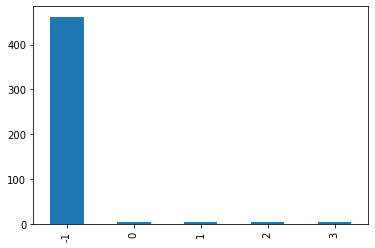

In [17]:
clas.clust.value_counts().sort_index().plot.bar()

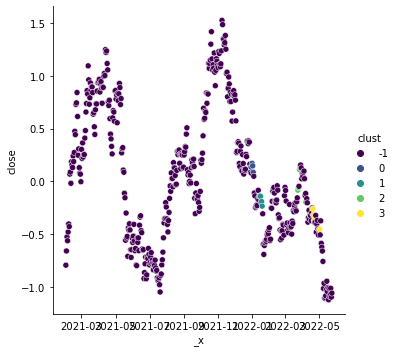

In [18]:
sns.relplot(y=df.close,x=df.index,hue=clas.clust,palette='viridis')


In [19]:
# get_dummies

---
# Classification


## *Train / Test Split*

In [20]:
train, val=tidy.split_ii(clas)

In [21]:
x=['cross', 'histy', 'atr_above_threshold_0.01',
       'atr_above_threshold_0.05', 'atr_above_threshold_0.1',
       'atr_above_threshold_0.2', 'atr_above_threshold_0.3',
       # 'clust'
       ]
y=['fwd_close_positive']


---
## Xy Split

In [22]:

X_train=train[x]
y_train=train[y]
X_val=val[x]
y_val=val[y]

## *KNN*

In [23]:
# weights = ['uniform', 'distance']
knn = KNeighborsClassifier(n_neighbors=10, weights='uniform')


In [24]:
knn.fit(X_train, y_train)


/usr/local/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier(n_neighbors=10)

In [25]:
y_pred = knn.predict(X_train)
y_pred_val = knn.predict(X_val)

pd.DataFrame(y_pred,columns=['class']).to_csv('classi_train_ii.csv')
pd.DataFrame(y_pred_val,columns=['class']).to_csv('classi_val_ii.csv')




In [26]:
y_pred_proba = knn.predict_proba(X_train)
y_pred_proba_val = knn.predict_proba(X_val)


In [27]:
print('Accuracy of KNN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))

print('Accuracy of KNN classifier on test set: {:.2f}'
     .format(knn.score(X_val, y_val)))


Accuracy of KNN classifier on training set: 0.52
Accuracy of KNN classifier on test set: 0.50


In [28]:
print(metrics.confusion_matrix(y_train, y_pred))
print(metrics.confusion_matrix(y_val, y_pred_val))


[[146  75]
 [142  85]]
[[11  3]
 [12  4]]


In [29]:
print(metrics.classification_report(y_train, y_pred))
print(metrics.classification_report(y_val, y_pred_val))


              precision    recall  f1-score   support

           0       0.51      0.66      0.57       221
           1       0.53      0.37      0.44       227

    accuracy                           0.52       448
   macro avg       0.52      0.52      0.51       448
weighted avg       0.52      0.52      0.51       448

              precision    recall  f1-score   support

           0       0.48      0.79      0.59        14
           1       0.57      0.25      0.35        16

    accuracy                           0.50        30
   macro avg       0.52      0.52      0.47        30
weighted avg       0.53      0.50      0.46        30



In [30]:
# k_range = range(1, 20)
# scores = []
# for k in k_range:
#     knn = KNeighborsClassifier(n_neighbors = k)
#     knn.fit(X_train, y_train)
#     scores.append(knn.score(X_val, y_val))
# plt.figure()
# plt.xlabel('k')
# plt.ylabel('accuracy')
# plt.scatter(k_range, scores)
# plt.xticks([0,5,10,15,20])
# plt.show()
